In [1]:
import networkx as nx

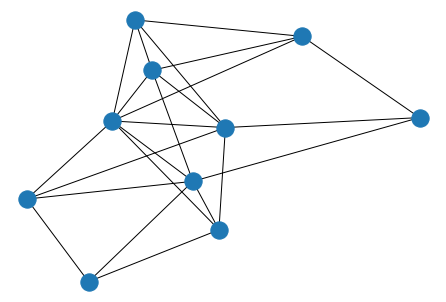

In [2]:
G = nx.erdos_renyi_graph(10, 0.5)
nx.draw(G)

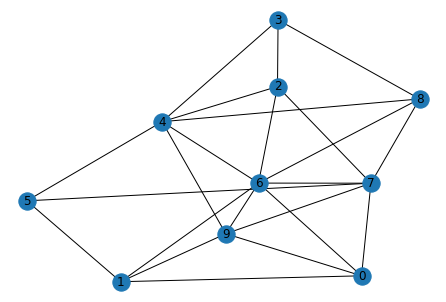

In [3]:
nx.draw(G, with_labels=True)

In [4]:
G.degree()

DegreeView({0: 4, 1: 4, 2: 4, 3: 3, 4: 6, 5: 3, 6: 7, 7: 6, 8: 4, 9: 5})

In [5]:
# degree centrality
s = 1 / (len(G)-1)
centrality = {n: d * s for n, d in G.degree()} # in_degree() or out_degree()
centrality

{0: 0.4444444444444444,
 1: 0.4444444444444444,
 2: 0.4444444444444444,
 3: 0.3333333333333333,
 4: 0.6666666666666666,
 5: 0.3333333333333333,
 6: 0.7777777777777777,
 7: 0.6666666666666666,
 8: 0.4444444444444444,
 9: 0.5555555555555556}

In [6]:
# for undirected graph
path_length = nx.single_source_shortest_path_length

closeness_centrality = {}
# for each node
for n in G.nodes:
    # shortest path from node n to all other nodes
    sp = path_length(G, n)
    # total shortest path lengths
    totsp = sum(sp.values())
    # total nodes
    len_G = len(G)

    _closeness_centrality = 0.0
    if totsp > 0.0 and len_G > 1:
        # (n-1)/sum(sp)
        _closeness_centrality = (len(sp) - 1.0) / totsp
        # normalise with Wasserman and Faust
        s = (len(sp) - 1) / (len_G - 1)
        _closeness_centrality *= s

    closeness_centrality[n] = _closeness_centrality
    
closeness_centrality

{0: 0.6,
 1: 0.6,
 2: 0.6428571428571429,
 3: 0.5294117647058824,
 4: 0.75,
 5: 0.6,
 6: 0.8181818181818182,
 7: 0.75,
 8: 0.6428571428571429,
 9: 0.6923076923076923}

In [7]:
list(G.neighbors(0)), G[0]

([1, 6, 7, 9], AtlasView({1: {}, 6: {}, 7: {}, 9: {}}))

In [8]:
def _single_source_shortest_path_basic(G, s):
    S = []
    P = {}
    # for each node in graph G
    for v in G:
        P[v] = []

    sigma = dict.fromkeys(G, 0.0)
    D = {}
    # shortest path from s to s
    sigma[s] = 1.0
    D[s] = 0
    # add current node s to the queue
    Q = [s]

    # use BFS to find shortest paths
    while Q:
        # get latest node
        v = Q.pop(0)
        # add node to S
        S.append(v)
        # get D value of node v
        Dv = D[v]

        sigmav = sigma[v]

        # get neighbors of v
        for w in G[v]:
            # if neighbor w is not visited yet
            if w not in D:
                # add to queue
                Q.append(w)
                # shortest path to v + 1
                D[w] = Dv + 1
            # this is shortest path, count this
            if D[w] == Dv + 1:
                sigma[w] += sigmav
                P[w].append(v)

    return S, P, sigma

In [9]:
_single_source_shortest_path_basic(G, 0)

([0, 1, 6, 7, 9, 5, 2, 4, 8, 3],
 {0: [],
  1: [0],
  2: [6, 7],
  3: [2, 4, 8],
  4: [6, 9],
  5: [1, 7],
  6: [0],
  7: [0],
  8: [6, 7],
  9: [0]},
 {0: 1.0,
  1: 1.0,
  2: 2.0,
  3: 6.0,
  4: 2.0,
  5: 2.0,
  6: 1.0,
  7: 1.0,
  8: 2.0,
  9: 1.0})

In [10]:
def _accummulate_basic(betweenness, S, P, sigma, s):
    delta = dict.fromkeys(S, 0)
    # retrace BFS
    while S:
        w = S.pop()
        coeff = (1 + delta[w]) / sigma[w]

        # loop over nodes in the path
        for v in P[w]:
            delta[v] += sigma[v] * coeff
        if w != s:
            betweenness[w] += delta[w]

    return betweenness

def _rescale(betweenness, n, normalized=True, directed=False, k=None, endpoints=False):
    if normalized:
        if endpoints:
            if n < 2:
                scale = None  # no normalization
            else:
                # Scale factor should include endpoint nodes
                scale = 1 / (n * (n - 1))
        elif n <= 2:
            scale = None  # no normalization b=0 for all nodes
        else:
            scale = 1 / ((n - 1) * (n - 2))
    else:  # rescale by 2 for undirected graphs
        if not directed:
            scale = 0.5
        else:
            scale = None
    if scale is not None:
        if k is not None:
            scale = scale * n / k
        for v in betweenness:
            betweenness[v] *= scale
    return betweenness


In [11]:
# betweenness
betweenness = dict.fromkeys(G, 0.0)

# loop through all nodes
for s in G:
    S, P, sigma = _single_source_shortest_path_basic(G, s)

    betweenness = _accummulate_basic(betweenness, S, P, sigma, s)

_rescale(betweenness, len(G))

{0: 0.006944444444444444,
 1: 0.0324074074074074,
 2: 0.04351851851851852,
 3: 0.006944444444444444,
 4: 0.1625,
 5: 0.027314814814814813,
 6: 0.175,
 7: 0.12268518518518516,
 8: 0.04351851851851852,
 9: 0.04583333333333333}

In [12]:
"""
current flow closeness centrality

equivalent to information centrality
1. calculate laplacian matrix
2. calculate inverse of the laplacian matrix
3. harmonic means of some elements of the inverse to get centrality
"""
# reverse cuthill mckee ordering
from networkx.utils import reverse_cuthill_mckee_ordering
# flow matrix
from networkx.algorithms.centrality.flow_matrix import (
    CGInverseLaplacian,
    FullInverseLaplacian,
    laplacian_sparse_matrix,
    SuperLUInverseLaplacian,
)

# order the graph
ordering = list(reverse_cuthill_mckee_ordering(G))

# relabel nodes
H = nx.relabel_nodes(G, dict(zip(ordering, range(n))))
H.nodes(), G.nodes(), ordering

# betweenness
betweenness = dict.fromkeys(H, 0.0)
# G_nodes - 1
n = H.number_of_nodes()
# create laplacian sparse matrix
L = laplacian_sparse_matrix(
    H, nodelist=range(n), weight=None, dtype=float, format="csc"
)

# calculate inverse of the laplacian matrix
C2 = SuperLUInverseLaplacian(L, width=1, dtype=None)

for v in H:
    col = C2.get_row(v)

    for w in H:
        betweenness[v] += col[v] - 2 * col[w]
        betweenness[w] += col[v]

for v in H:
    betweenness[v] = 1 / betweenness[v]

{ordering[k]: float(v) for k, v in betweenness.items()}

{0: 0.27248120300751877,
 1: 0.2760932500380923,
 2: 0.2770430395229722,
 5: 0.31333218052913714,
 4: 0.31316972001382637,
 6: 0.371997536440156,
 7: 0.3465952563121653,
 8: 0.2770430395229722,
 9: 0.31219848380427295}

In [13]:
"""
current flow betweenness

also known as random-walk betweenness centrality
"""
# reverse cuthill mckee ordering
from networkx.utils import reverse_cuthill_mckee_ordering
# flow matrix
from networkx.algorithms.centrality.flow_matrix import (
    CGInverseLaplacian,
    FullInverseLaplacian,
    laplacian_sparse_matrix,
    SuperLUInverseLaplacian,
    flow_matrix_row
)

n = G.number_of_nodes()

# order the graph
ordering = list(reverse_cuthill_mckee_ordering(G))

# relabel nodes
H = nx.relabel_nodes(G, dict(zip(ordering, range(n))))

# betweenness
betweenness = dict.fromkeys(H, 0.0)

for row, (s, t) in flow_matrix_row(H, weight=None, dtype=float, solver='full'):
    pos = dict(zip(row.argsort()[::-1], range(n)))

    for i in range(n):
        betweenness[s] += (i - pos[i]) * row[i]
        betweenness[t] += (n - i - 1 - pos[i]) * row[i]

    nb = 2.0

    for v in H:
        betweenness[v] = float((betweenness[v] - v) * 2.0 / nb)

{ordering[k]: float(v) for k, v in betweenness.items()}

{0: -17.759556697719244,
 1: 5.253292643752009,
 2: -148.6632669450691,
 3: -194.5705107613234,
 4: -121.98233215547701,
 5: -61.93768069386444,
 6: -77.56135560552522,
 7: -100.74269193703826,
 8: -170.66326694506913,
 9: -37.852232573080634}

{0: 0.1, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.1, 6: 0.1, 7: 0.1, 8: 0.1, 9: 0.1}
{0: 0.29660556734748916, 1: 0.2668106791185909, 2: 0.28073889085342085, 3: 0.18729819314662804, 4: 0.35883454717157776, 5: 0.20488466022543614, 6: 0.45223142400181526, 7: 0.381080335957624, 8: 0.28073889085342085, 9: 0.3572848954934032}


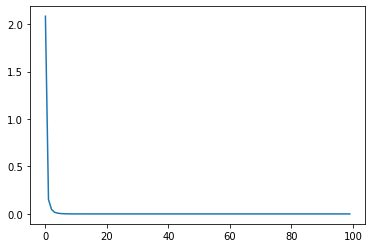

In [14]:
import numpy as np
import matplotlib.pyplot as plt
# eigenvector centrality

# start with all-ones vector
nstart = {v: 1 for v in G}

# normalise initial vector so each entry is in [0, 1]
nstart_sum = sum(nstart.values())
x = {k: v / nstart_sum for k, v in nstart.items()}

print(x)

# number of nodes
nnodes = G.number_of_nodes()

max_iter = 100
diff = []
# iterate until converging
for i in range(max_iter):
    xlast = x
    x = xlast.copy()

    # do the y^T = x^T A (left eigenvector) multiplication
    # for each vertex
    for n in x:
        # for neighbors of n
        for nbr in G[n]:
            w = 1
            # neighbor's value is incremented by x's value
            x[nbr] += xlast[n] * w

    # normalise value
    norm = np.sqrt(sum(z ** 2 for z in x.values())) or 1
    x = {k: v / norm for k, v in x.items()}

    # check for convergence
    diff.append(sum(abs(x[n] - xlast[n]) for n in x))
print(x)

plt.plot(diff)

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}
{0: 0.31127825605858334, 1: 0.31059314210459, 2: 0.31123957628806226, 3: 0.3017652299219769, 4: 0.32748560415253786, 5: 0.3022023571132147, 6: 0.3367557900530987, 7: 0.3277477694273258, 8: 0.31123957628806226, 9: 0.3200612404308066}


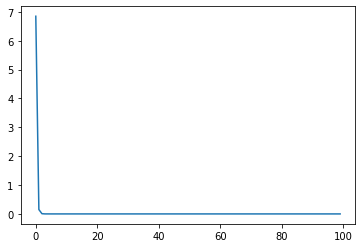

In [15]:
"""
Katz Centrality
"""

alpha=0.1
beta=1.0
max_iter=1000
tol=1.0e-6
nstart=None
normalized=True
weight=None

nnodes = G.number_of_nodes()

# starting vector
nstart = {v: 1 for v in G}
x = nstart

print(x)

# starting beta value
b = dict.fromkeys(G, float(beta))

max_iter = 100
diff = []
# iterate until converging
for i in range(max_iter):
    xlast = x
    x = dict.fromkeys(xlast, 0)

    # do the multiplication y^T = Alpha * x^T A - Beta
    # for each vertex
    for n in x:
        # for neighbors of n
        for nbr in G[n]:
            # neighbor's value is incremented by x's value
            x[nbr] += xlast[n] * G[n][nbr].get(weight, 1)

    for n in x:
        x[n] = alpha * x[n] + b[n]


    # normalise value
    norm = np.sqrt(sum(z ** 2 for z in x.values())) or 1
    x = {k: v / norm for k, v in x.items()}

    # check for convergence
    diff.append(sum(abs(x[n] - xlast[n]) for n in x))

print(x)

plt.plot(diff)

In [16]:
# nx.communicability(G)

# list of nodes
nodelist = list(G)
# adjacency matrix
A = nx.to_numpy_array(G, nodelist)

# eigenvector decomposition
w, vec = np.linalg.eigh(A)

# exponentials of eigenvalues
expw = np.exp(w)

mapping = dict(zip(nodelist, range(len(nodelist))))

c = {}

# for nodes in G
for u in G:
    c[u] = {}

    for v in G:
        s = 0
        # p = mapping[u]
        # q = mapping[v]
        p = u
        q = v

        for j in range(len(nodelist)):
            # jth eigenvector (uth element) * jth eigenvector (vth element) * exponent(jth eigenvalue)
            s += vec[:, j][p] * vec[:, j][q] * expw[j]
        
        # communicability between u and v is 
        c[u][v] = float(s)

c

{0: {0: 13.630458950934603,
  1: 11.905317417469337,
  2: 10.317813206689696,
  3: 6.14291361248655,
  4: 13.216259158964936,
  5: 8.110647094957207,
  6: 18.51590910652574,
  7: 15.659510190787765,
  8: 10.317813206689694,
  9: 15.307184716380947},
 1: {0: 11.905317417469337,
  1: 11.475435497820799,
  2: 9.08271367027594,
  3: 5.459603430060568,
  4: 12.065423479317955,
  5: 7.927429006834857,
  6: 16.57786809230484,
  7: 13.704173560876153,
  8: 9.082713670275936,
  9: 13.80672271779678},
 2: {0: 10.317813206689696,
  1: 9.08271367027594,
  2: 12.203161140932572,
  3: 8.387886998966962,
  4: 14.480665786916482,
  5: 7.514681188447343,
  6: 17.16040555081202,
  7: 14.477304231066665,
  8: 11.203161140932568,
  9: 12.814168616610434},
 3: {0: 6.14291361248655,
  1: 5.459603430060568,
  2: 8.387886998966962,
  3: 7.060102733657839,
  4: 10.475189951597898,
  5: 4.916174380178089,
  6: 11.131176068447221,
  7: 9.220519315078626,
  8: 8.38788699896696,
  9: 8.040586758757907},
 4: {0: 13

In [17]:
A

array([[0., 1., 0., 0., 0., 0., 1., 1., 0., 1.],
       [1., 0., 0., 0., 0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 1., 1., 0., 1., 1., 0., 1., 1.],
       [0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
       [1., 1., 1., 0., 1., 0., 0., 1., 1., 1.],
       [1., 0., 1., 0., 0., 1., 1., 0., 1., 1.],
       [0., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0., 1., 1., 0., 0.]])

In [18]:
import scipy as sc

# communicability betweenness

# list of nodes
nodelist = list(G)
n = len(nodelist)
# adjacency matrix
A = nx.to_numpy_array(G, nodelist)

# compute matrix exponential e^A
expA = sc.linalg.expm(A)

mapping = dict(zip(nodelist, range(n)))
cbc = {}

# for each vertex in node
for v in G:
    # remove row and col of node v
    i = mapping[v]
    row = A[i, :].copy()
    col = A[i, :].copy()
    
    # set row i (or v) to 0 - remove edges of r
    A[i, :] = 0
    A[:, i] = 0

    # calculate B
    # [ (e^A)_pq - e^(A+E(v)) ] (e^A)_pq
    B = (expA - sc.linalg.expm(A)) / expA
    # don't consider node v
    B[i, :] = 0
    B[:, i] = 0

    # remove diagonal elements (p != q)
    # diagonal matrix = tr(B) the rest is 0
    B -= np.diag(np.diag(B))

    cbc[v] = float(B.sum())

    # restore adjacency matrix
    A[i, :] = row
    A[:, i] = col

# rescaling
order = len(cbc)
scale = 1.0 / ((order - 1.0) ** 2 - (order - 1.0))
for v in cbc:
    cbc[v] *= scale

cbc
# A[0, :], A[:, 0]

{0: 0.262753036259145,
 1: 0.2333278396504163,
 2: 0.2785476805012056,
 3: 0.1261985387324468,
 4: 0.4689446183712776,
 5: 0.15061640602032855,
 6: 0.6224691674673959,
 7: 0.47947233222606395,
 8: 0.2785476805012055,
 9: 0.3954892478363621}

In [19]:
# matrix exponential. only works for < 1 element

A = np.array([[-49, 24], [-64, 31]]) / 100
# A = np.array([[0.5, 0.2], [0.1, 0.9]])

add = np.eye(2)
for i in range(1, 47):
    add += np.linalg.matrix_power(A, i) / sc.special.factorial(i)

add, sc.linalg.expm(A)

(array([[ 0.55089478,  0.21957753],
        [-0.58554007,  1.28281987]]),
 array([[ 0.55089478,  0.21957753],
        [-0.58554007,  1.28281987]]))

In [20]:
# subgraph centrality
# Estrada index is basically sum of subgraph centrality
# sum of weighted closed walks of all lengths

import numpy as np
import numpy.linalg

# adjacency matrix
nodelist = list(G)
A = nx.to_numpy_array(G, nodelist)

# eigenvalues, eigenvectors decomposition
w, v = np.linalg.eigh(A)

# v square
vsquare = np.array(v) ** 2
# matrix exponential of w
expw = np.exp(w)

# v^T . e^W
xg = np.dot(vsquare, expw)

# convert vector dictionary keyed by node
sc = dict(zip(nodelist, map(float, xg)))
sc, np.dot(v[0]**2, expw)

({0: 13.630458950934601,
  1: 11.475435497820799,
  2: 12.203161140932572,
  3: 7.060102733657839,
  4: 18.96248236514209,
  5: 7.026534343901535,
  6: 28.231385585373037,
  7: 20.518204998362997,
  8: 12.203161140932568,
  9: 18.443481564332835},
 13.630458950934603)

In [21]:
# dispersion(G, u, v)
# results = _dispersion(G, u, v)
u = 0
v = 1

# dispersion for all nodes 'v' in an ego network G(u)
# neighbors of u
u_nbrs = set(G[u])
# common neighbors of u and v
ST = {n for n in G[v] if n in u_nbrs}
set_uv = {u, v}

# all possible ties of connections
from itertools import combinations

# combinatorics of common neighbors
possib = combinations(ST, 2)
total = 0

# count how many non common neighbors
# loop every pair of combination (common neighbors)
for (s, t) in possib:
    # neighbors of 1st pair s
    nbrs_s = u_nbrs.intersection(G[s]) - set_uv
    # for non common neighbors
    if t not in nbrs_s:
        if nbrs_s.isdisjoint(G[t]):
            total += 1

# number of common neighbors
embededness = len(ST)

norm_disp = total ** alpha
norm_disp /= embededness

norm_disp

0.0

In [22]:
from networkx.algorithms.centrality.betweenness import (
    _single_source_shortest_path_basic as shortest_path,
)

# percolation centrality

percolation = dict.fromkeys(G, 0.0)
nodes = G
n = len(G)

# percolation states
# random states
states = dict(zip(G, np.random.rand(len(G))))

# sum of percolation values across all nodes
p_sigma_x_t = 0.0
for v in states.values():
    p_sigma_x_t += v

# for all nodes
for s in nodes:
    # get shortest path from s to all
    S, P, sigma = shortest_path(G, s)

    # accummulate percolation
    delta = dict.fromkeys(S, 0)
    # loop over all nodes based on BFS order from s
    while S:
        w = S.pop()
        coeff = (1 + delta[w]) / sigma[w]
        for v in P[w]:
            delta[v] += sigma[v] * coeff

        if w != s:
            # percolation weight
            pw_s_w = states[s] / (p_sigma_x_t - states[w])
            percolation[w] += delta[w] * pw_s_w



# normalise percolation
for v in percolation:
    percolation[v] /= (n - 2)

percolation

{0: 0.005289481226558632,
 1: 0.042117542744327496,
 2: 0.040271884851586684,
 3: 0.007431366949665935,
 4: 0.16583235744828173,
 5: 0.017387576218229096,
 6: 0.1547824125139779,
 7: 0.1605115071861011,
 8: 0.03593484881531256,
 9: 0.03692450680676352}

In [23]:
2/7

0.2857142857142857

In [24]:
# second order centrality
n = len(G)

# for undirected graph, in and out degree become the same
dG = nx.DiGraph(G)
in_deg = dict(dG.in_degree())
# maximum degree
d_max = max(in_deg.values())

# for each node's degree
for i, deg in in_deg.items():
    if deg < d_max:
        # add self loop
        dG.add_edge(i, i, weight=d_max-deg)

# adjacency matrix
P = nx.to_numpy_array(dG)
# normalise to probability matrix
P /= P.sum(axis=1)[:, np.newaxis]

# set column j to 0
def _Qj(P, j):
    P = P.copy()
    P[:, j] = 0
    return P

# empty adjacency matrix
M = np.empty([n, n])

# for each column
for i in range(n):
    # solve linear algebra equation ( I - P)x = 1
    M[:, i] = np.linalg.solve(
        np.identity(n) - _Qj(P, i), np.ones([n, 1])[:, 0]
    )
# calculate standard deviation
std = [np.sqrt(2 * np.sum(M[:, i]) - n*(n+1)) for i in range(n)]

dict(zip(G.nodes, std))

{0: 15.719043839324783,
 1: 15.79183164408842,
 2: 15.276875019971943,
 3: 19.385566608694237,
 4: 10.809598238141358,
 5: 18.238048289132333,
 6: 9.07982941914428,
 7: 10.584674566988149,
 8: 15.276875019971945,
 9: 12.957292273641423}

In [25]:
# from networkx.algorithms import centrality
# centrality.trophic_levels(dG)

dG = G.to_directed()

# trophic level
a = nx.adjacency_matrix(dG).T.toarray()

# filter rows where in-degree are zeroes (sources)
rowsum = np.sum(a, axis=1)
p = a[rowsum != 0][:, rowsum != 0]
p = p / rowsum[rowsum != 0][:, np.newaxis]

# calculate trophic levels
nn = p.shape[0] # number of nodes
i = np.eye(nn) # identity matrix

# iminp (diagonal = 1, the rest sums up to 1)
iminp = i - p
n = np.linalg.inv(i - p)

# sum of (i - p)^-1
y = n.sum(axis=1)+1

levels = {}

# all nodes with trophic level == 1 (zero in-degree)
zero_node_ids = (node_id for node_id, degree in dG.in_degree if degree == 0)
for node_id in zero_node_ids:
    levels[node_id] = 1

nonzero_node_ids = (node_id for node_id, degree in dG.in_degree if degree != 0)
for i, node_id in enumerate(nonzero_node_ids):
    levels[node_id] = y[i]

levels

{0: 3.314649325744685e+16,
 1: 3.314649325744685e+16,
 2: 3.314649325744685e+16,
 3: 3.3146493257446852e+16,
 4: 3.314649325744685e+16,
 5: 3.314649325744685e+16,
 6: 3.3146493257446844e+16,
 7: 3.3146493257446844e+16,
 8: 3.3146493257446852e+16,
 9: 3.3146493257446844e+16}

In [26]:
# calculate trophic differences
diffs = {}
# trophic difference per edges
for u, v in dG.edges():
    diffs[(u, v)] = levels[v] - levels[u]

# trophic incoherence = standard deviation of distribution (trophic differences) across all edges
np.std(list(diffs.values()))

3.8221323436236365

In [27]:
# TODO: revise trophic coherence paper by Samuel Johnson et al

In [28]:
# VoteRank

influential_nodes = []
voterank = {}

# average degree
avgDegree = sum(deg for _, deg in G.degree()) / len(dG)

# 1. initiate all nodes to (0, 1) - (score, voting ability)
for n in G.nodes():
    voterank[n] = [0, 1]


#
number_of_nodes = len(G)
for _ in range(number_of_nodes):
    # reset every node's voteRank to 0
    for n in G.nodes():
        # score
        voterank[n][0] = 0
        
    # for every edge
    for n, nbr in G.edges():
        # add current node n's votes from all neighbors
        voterank[n][0] += voterank[nbr][1]
        voterank[nbr][0] += voterank[n][1]

    for n in influential_nodes:
        voterank[n][0] = 0

    # 3. select top node
    n = max(G.nodes, key=lambda x: voterank[x][0])
    influential_nodes.append(n)

    # weaken top node
    voterank[n] = [0, 0]

    # 4. update voterank props
    for _, nbr in G.edges(n):
        # reduce voting availability for neighbors of influential_node n
        voterank[nbr][1] -= 1 / avgDegree
        # cap at zero
        voterank[nbr][1] = max(voterank[nbr][1], 0)

    # print(n)

    # break

influential_nodes

[6, 4, 7, 1, 2, 8, 9, 0, 0, 0]

In [29]:
nx.algorithms.centrality.voterank(G)

[6, 4, 7, 1, 2, 8, 9]

In [30]:
G.degree()

DegreeView({0: 4, 1: 4, 2: 4, 3: 3, 4: 6, 5: 3, 6: 7, 7: 6, 8: 4, 9: 5})

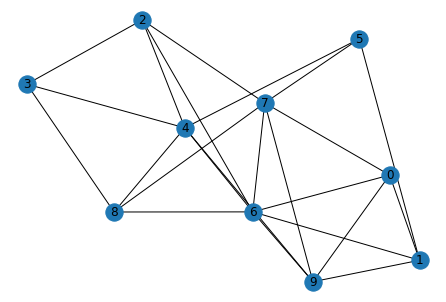

In [31]:
nx.draw(G, with_labels=True)